Reattempting the model in Tensorflow, because autograd.grad can only return the gradient after it has summed all the values, but I need them individually.
Built off of the structure of the original PyTorch code.

Just like mentioned before, I should really be using object-oriented programming. I didn't here because I am mainly just swapping out the PyTorch code for Tensorflow piece by piece.

Import Statements

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy.io

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

Some Variables

In [75]:
#number of intermediate steps
q = 500

#step size
h = 0.8

#start and end location
start_t = 0.1
end_t = start_t + h

N = 100 #number of x values for training

Import Data

In [76]:
#CREDIT TO https://github.com/maziarraissi/PINNs/blob/master/appendix/discrete_time_inference%20(Burgers)/Burgers_systematic.py FOR THE BELOW CODE TO IMPORT IRK WEIGHTS AND THE LABEL DATA (AND FOR THE DATA ITSELF)

tmp = np.float32(np.loadtxt('./data/Butcher_IRK%d.txt' % (q), ndmin = 2))
IRK_weights = np.reshape(tmp[0:q**2+q], (q+1,q)) #presume the first q rows and q columns represent a_{ij} values, and the final row represents the b_j values
IRK_times = tmp[q**2+q:] #not sure what this is used for


#I may choose to generate my own data once more...
'''
data = scipy.io.loadmat('./data/burgers_shock.mat')

t_points = data['t'].flatten()[:,None] # T x 1
x_points = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['usol']).T # T x N

#get data labels at t = 0.9 
index = np.where(t_points == end_t)[0][0]
end_labels = Exact[index, :]'''

"\ndata = scipy.io.loadmat('./data/burgers_shock.mat')\n\nt_points = data['t'].flatten()[:,None] # T x 1\nx_points = data['x'].flatten()[:,None] # N x 1\nExact = np.real(data['usol']).T # T x N\n\n#get data labels at t = 0.9 \nindex = np.where(t_points == end_t)[0][0]\nend_labels = Exact[index, :]"

Generate Data

In [77]:
input = np.random.rand(N) * 2 - 1 #x values between -1 and 1

initial_vals = -np.sin(input * np.pi) #initial values at t = 0

Define Network

In [78]:
pinn = Sequential([
    Dense(50, activation = 'tanh', input_shape=(1,)),
    Dense(50, activation = 'tanh'),
    Dense(50, activation = 'tanh'),
    Dense(50, activation = 'tanh'),
    Dense(50, activation = 'tanh'),
    Dense(50, activation = 'tanh'),
    Dense(q + 1)
])

Helper Methods

In [79]:
#Nonelinear Burgers' Operator
@tf.function
def NLO(input, outputs, tape): #outputs is of the form N x q. Inputs is of form N x 1 and was used to get outputs


    #with tf.GradientTape(persistent=True) as tape:
        #tape.watch(input)
    u = outputs

    u_x = tape.batch_jacobian(u, input)
    u_x = tf.squeeze(u_x, axis=-1)

    u_xx = tape.batch_jacobian(u_x, input)
    u_xx = tf.squeeze(u_xx, axis=-1)

    #del tape

    tf.print("u", u[0,:10])
    tf.print("u_x", u_x[0,:10])
    tf.print("u_xx", u_xx[0,:10])

    #print("begin")
    #tf.print("u", tf.shape(u))
    #tf.print("u_x", tf.shape(u_x))
    #tf.print("u_xx", tf.shape(u_xx))
    #print("end")


    return u * u_x - (0.01/math.pi)*u_xx
    
    


#Implicit Runge-Kutta Calculation (Combine Intermediate Terms with Butcher Tableau Coefficients)
#@tf.function
def IRK(input, outputs, initial_vals, coefficients, tape): #outputs is tensor of size Nx(q+1), represnting q stages for N x-values and the final n+1 prediction. coefficients is a tensor of size (q+1) x q representing the Butcher Tableau. Input and initial_vals are size (N)

    global N
    global q
    global h

    outputs_truncated = outputs[:, :-1] #get all but last row

    NLO_outputs = NLO(input, outputs_truncated, tape) #perform non-linear operation on each of the outputs_truncated. Shape is still (N, q)


    N_coefficients = tf.tile(tf.expand_dims(coefficients, 0), [N, 1, 1]) #stack N coefficients tensors on top of each other
    NLO_outputs = tf.expand_dims(NLO_outputs, axis=-1) #reshape NLO_outputs_reshaped into shape (N, q, 1) for matrix multiplication

    coefficients_applied = tf.linalg.matmul(N_coefficients, NLO_outputs) #perform matrix multiplication. This represents applying the coefficients a_{ij} (and b_i for n+1 prediction) from the Butcher Tableau to every element in NLO_outputs and THEN recombining them to make every new value which will go on to form the "calculated" outputs (intermediate stage values). Has shape (N, q+1, 1), since N_coefficients has shape (N, q+1, q) and NLO_outputs has shape (N, q, 1). For each layer in N, the matrix mulitplcaion (q+1, q) x (q, 1) takes place, resulting in a vector of shape (q+1, 1). N of these makes (N, q+1, 1)
    coefficients_applied = tf.reshape(coefficients_applied, [N, -1]) #now shape (N, q + 1)

    coefficients_applied = -h * coefficients_applied #apply the -h (-\delta t) to each element in coefficients_applied
    initial_vals = tf.reshape(initial_vals, [-1, 1]) #reshape initial_vals from (N) to (N, 1)



    result = coefficients_applied + initial_vals #Every element in coefficients_applied has a value added to it which is the element from initial_vals on the same layer. We can add the shapes (N, q+1) and (N, 1) due to "broadcasting", which effectively stretches the shape of the vector

    return result #returns a result which is the same shape as "outputs" and represents the same intermediate values, except these are the "calculated" versions and not the "direct predictions"



Loss Functions

In [80]:
#@tf.function
def SSE_n(input, outputs, initial_vals, coefficients, tape):

    calculated_outputs = IRK(input, outputs, initial_vals, coefficients, tape)

    SSE_n_loss = tf.reduce_sum(tf.square(calculated_outputs - outputs))

    return SSE_n_loss


#@tf.function
def SSE_b(model):
    boundary_points = tf.constant([-1, 1], shape=(2,1))
    boundary_results = model(boundary_points) #get all intermediary points and the n+1 prediction for x = -1 and 1
    return tf.reduce_sum(tf.square(boundary_results)) #square results and sum them


@tf.function
def SSE(input, outputs, initial_vals, coefficients, model, tape):
    SSE_n_loss = SSE_n(input, outputs, initial_vals, coefficients, tape)
    SSE_b_loss = SSE_b(model)
    return SSE_n_loss + SSE_b_loss, SSE_n_loss, SSE_b_loss

Training Setup

In [81]:
input = tf.constant(input, dtype=tf.float32)
initial_vals = tf.constant(initial_vals, dtype=tf.float32)
coefficients = tf.constant(IRK_weights, dtype=tf.float32)

input = tf.reshape(input, [-1, 1])
initial_vals = tf.reshape(initial_vals, [-1, 1])

Training

In [82]:
optimizer = tf.keras.optimizers.legacy.Adam()

num_epochs = 1
i = 0
for epoch in range(num_epochs):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input)

        outputs = pinn(input)

        
        

    u = outputs
    
    u_x = tape.batch_jacobian(u, input)
    u_x = tf.squeeze(u_x, axis=-1)

    u_xx = tape.batch_jacobian(u_x, input)
    u_xx = tf.squeeze(u_xx, axis=-1)

    #del tape

    tf.print("u", u[0,:10])
    tf.print("u_x", u_x[0,:10])
    tf.print("u_xx", u_xx[0,:10])








        #overall_loss, SSE_n_loss, SSE_b_loss = SSE(input, outputs, initial_vals, coefficients, pinn, tape)
    
    grads = tape.gradient(overall_loss, pinn.trainable_variables)

    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))

    if i % 100 == 0:
        print(f"STEP: {i} | Avg Losses | SSE_n: {SSE_n_loss} | SSE_b: {SSE_b_loss} | Total: {overall_loss}")
    
    i += 1



u [0.0282184668 -0.00947512 -0.0840042 ... 0.0180421341 -0.018635 -0.0396642797]
u_x [-0.048858583 0.0170418229 0.144047543 ... -0.0331687331 0.031710282 0.0666879341]
u_xx [-0.048858583 0.0170418229 0.144047543 ... -0.0331687331 0.031710282 0.0666879341]


ValueError: No gradients provided for any variable: (['dense_56/kernel:0', 'dense_56/bias:0', 'dense_57/kernel:0', 'dense_57/bias:0', 'dense_58/kernel:0', 'dense_58/bias:0', 'dense_59/kernel:0', 'dense_59/bias:0', 'dense_60/kernel:0', 'dense_60/bias:0', 'dense_61/kernel:0', 'dense_61/bias:0', 'dense_62/kernel:0', 'dense_62/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_56/kernel:0' shape=(1, 50) dtype=float32, numpy=
array([[-0.00844067,  0.19929829, -0.04475093, -0.32642967, -0.32389072,
         0.10011765, -0.14665869,  0.24121878, -0.05571207, -0.01272538,
        -0.25689936, -0.07804534, -0.20356068,  0.03439102,  0.31957397,
         0.33885965, -0.04418463,  0.34222165,  0.0792132 , -0.06548145,
         0.33061162, -0.2986341 ,  0.2827237 ,  0.03315899,  0.23801449,
        -0.21613151, -0.07615644, -0.2534719 ,  0.0822871 ,  0.29390582,
         0.16072777, -0.14025228, -0.11353421,  0.13234052, -0.07662666,
         0.28972223,  0.18054476, -0.02670595, -0.07487485, -0.24837835,
         0.04832059, -0.02018237,  0.24200729,  0.26092693, -0.1925011 ,
         0.04627427, -0.29848984, -0.01642743, -0.25619346,  0.03946316]],
      dtype=float32)>), (None, <tf.Variable 'dense_56/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_57/kernel:0' shape=(50, 50) dtype=float32, numpy=
array([[ 0.10349704,  0.14887221, -0.17790328, ...,  0.14604382,
        -0.23001797,  0.03250881],
       [-0.09458667, -0.00709237, -0.20268327, ...,  0.05644397,
         0.16658588, -0.14936167],
       [ 0.2346629 ,  0.13781895, -0.11833735, ...,  0.16676383,
        -0.10507281, -0.02772418],
       ...,
       [ 0.17972352,  0.0090913 ,  0.1641324 , ..., -0.20882735,
        -0.22197151,  0.22383617],
       [-0.08326721,  0.17606886, -0.1519633 , ...,  0.06708626,
         0.13761841, -0.08319817],
       [-0.22345167,  0.09713696,  0.13138784, ...,  0.21803977,
         0.21892862,  0.22797291]], dtype=float32)>), (None, <tf.Variable 'dense_57/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_58/kernel:0' shape=(50, 50) dtype=float32, numpy=
array([[ 0.00210428, -0.20400235,  0.025304  , ..., -0.07096319,
        -0.17115214, -0.05887507],
       [-0.05347507, -0.04149003,  0.0892428 , ...,  0.18171011,
         0.04587953,  0.04124452],
       [ 0.16155542, -0.15916803,  0.04552619, ...,  0.20864688,
         0.23356263, -0.07891013],
       ...,
       [ 0.20141943,  0.00242992, -0.1465949 , ..., -0.21699475,
         0.0041858 , -0.01410854],
       [-0.1356833 ,  0.18997674, -0.1123113 , ...,  0.11992858,
        -0.13257577, -0.19368587],
       [ 0.07112075, -0.22096036, -0.16001138, ...,  0.01704212,
         0.0194013 , -0.00638457]], dtype=float32)>), (None, <tf.Variable 'dense_58/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_59/kernel:0' shape=(50, 50) dtype=float32, numpy=
array([[-0.00346915,  0.00355226, -0.20024785, ..., -0.19898115,
        -0.23433329,  0.04185025],
       [-0.11657073,  0.03191967, -0.03487262, ..., -0.01238053,
        -0.18878385,  0.03921108],
       [ 0.17706172,  0.01460014,  0.06137009, ...,  0.08327557,
         0.05767272, -0.17122433],
       ...,
       [ 0.11528106, -0.0622575 , -0.19146204, ...,  0.0780402 ,
        -0.0350703 ,  0.10313199],
       [-0.11344391, -0.22670949,  0.07328992, ..., -0.19996935,
        -0.04913312,  0.04851915],
       [-0.15208411,  0.1441388 , -0.16458665, ..., -0.1851854 ,
         0.06610428, -0.04544297]], dtype=float32)>), (None, <tf.Variable 'dense_59/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_60/kernel:0' shape=(50, 50) dtype=float32, numpy=
array([[ 0.2318139 , -0.03920236,  0.0742978 , ...,  0.17576827,
         0.01505499,  0.21473776],
       [-0.19604105, -0.01032197,  0.19028719, ..., -0.13120067,
         0.17173235,  0.19224338],
       [-0.09968561,  0.09000276,  0.11954595, ..., -0.22334492,
        -0.10493585, -0.23521334],
       ...,
       [-0.11249924, -0.07675329,  0.09227137, ..., -0.0534482 ,
         0.04414918,  0.03990819],
       [-0.16938278, -0.13786298, -0.17493945, ..., -0.09137931,
        -0.12169951,  0.08776696],
       [ 0.11462747, -0.22415125,  0.17548124, ..., -0.16568556,
         0.03226154, -0.11310087]], dtype=float32)>), (None, <tf.Variable 'dense_60/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_61/kernel:0' shape=(50, 50) dtype=float32, numpy=
array([[-0.07975227, -0.11169237,  0.02561183, ..., -0.13896471,
         0.03261013, -0.01054274],
       [-0.21647486, -0.11982468,  0.15417735, ..., -0.13151562,
         0.07612951, -0.2022865 ],
       [ 0.00750218, -0.20910953, -0.04132633, ...,  0.06187691,
         0.02815826,  0.09702335],
       ...,
       [-0.06060733, -0.00619827,  0.22268347, ..., -0.11828057,
        -0.21682674,  0.03982784],
       [-0.0715699 , -0.19459009, -0.0896659 , ...,  0.09210484,
        -0.09803094,  0.04346062],
       [-0.21787228, -0.21993993, -0.00083378, ...,  0.1573172 ,
         0.1625431 ,  0.22770543]], dtype=float32)>), (None, <tf.Variable 'dense_61/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_62/kernel:0' shape=(50, 501) dtype=float32, numpy=
array([[ 0.03272097, -0.00700019, -0.05399276, ..., -0.01126927,
        -0.03021324, -0.05036887],
       [ 0.01951951,  0.08595888, -0.05993582, ..., -0.09497333,
         0.10250455, -0.08155356],
       [ 0.10073902,  0.01291318, -0.07955778, ...,  0.02427804,
         0.10161103, -0.10311592],
       ...,
       [-0.09154281,  0.01001625,  0.07564135, ...,  0.04184087,
        -0.09774495,  0.02073255],
       [ 0.03446029, -0.05741109, -0.03220596, ...,  0.0372628 ,
         0.02988735, -0.01046412],
       [-0.09371381,  0.01287808, -0.01453853, ...,  0.06465241,
         0.10399508, -0.02220509]], dtype=float32)>), (None, <tf.Variable 'dense_62/bias:0' shape=(501,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)).

Evaluation

Graphing

32/32 [==============================] - 0s 381us/step
Size: 1000
[0.96812795 0.96653358 0.96490097 0.96323019 0.96152131 0.95977439
 0.95798951 0.95616673 0.95430613 0.95240778]
[-0.0103075  -0.01024654 -0.01018548 -0.01012433 -0.01006304 -0.01000161
 -0.00994009 -0.00987844 -0.00981667 -0.00975477]


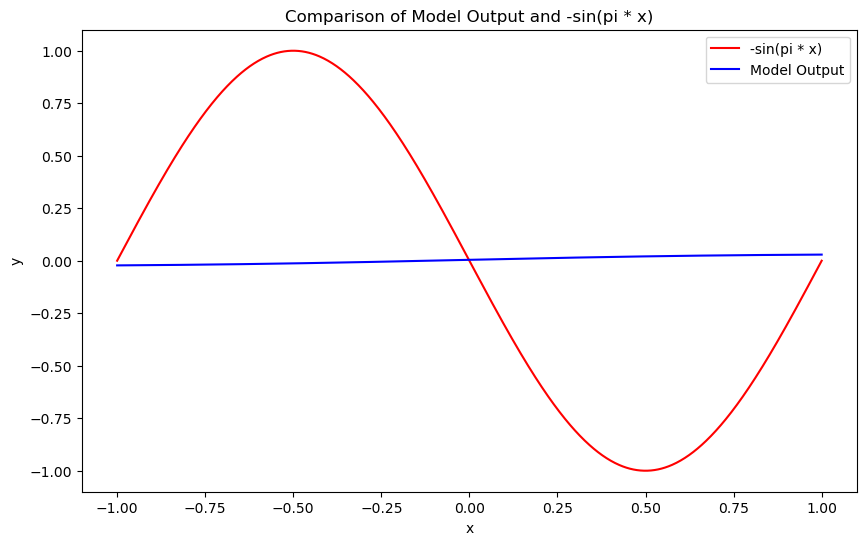

In [ ]:
num_points = 1000
x_vals = np.linspace(-1, 1, num_points)

# Reshape for model input
x_vals_model = x_vals.reshape(-1, 1).astype(np.float32)

# Plug these points through the model
model_output = pinn.predict(x_vals_model)

# Take the q+1th output of the model (last output)
final_output = model_output[:, 500]

print(f"Size: {len(final_output)}")

# Plug the original points through the function -sin(pi * x)
y_vals = -np.sin(np.pi * x_vals)

print(y_vals[290:300])
print(final_output[290:300])

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(x_vals, y_vals, 'r', label='-sin(pi * x)')
plt.plot(x_vals, final_output, 'b', label='Model Output')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Output and -sin(pi * x)')
plt.show()

Saving